In [1]:
import tensorflow as tf
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
from glob import glob
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add, Attention, Reshape
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical,Sequence,plot_model
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

2025-06-28 11:05:05.042874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751108705.258669      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751108705.320679      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
model = VGG16()
model = Model(inputs=model.input,outputs=model.layers[-2].output)

I0000 00:00:1751108719.242542      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751108719.243232      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
features={}
directory="/kaggle/input/flickr/Flickr8k_Dataset/Flicker8k_Dataset"
if not os.path.isfile("features.pkl"):
    for img_path in tqdm(glob(os.path.join(directory, "*.jpg"))):
        img = load_img(img_path, target_size=(224,224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x, verbose=0)
        img_id = os.path.basename(img_path).split('.')[0]
        features[img_id] = feature
    with open("features.pkl", "wb") as f:
        pickle.dump(features, f)
    print("✅ features.pkl created")
else:
    print("⚠️ features.pkl already exists — skipping dump")
!ls -lh features.pkl

  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1751108725.928515     101 service.cc:148] XLA service 0x7dca34006b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751108725.929299     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751108725.929318     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751108726.068811     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751108728.644425     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [12:57<00:00, 10.40it/s]


✅ features.pkl created
-rw-r--r-- 1 root root 127M Jun 28 11:18 features.pkl


In [4]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [5]:
captions_path = "/kaggle/input/flickr/Flickr8k_text/Flickr8k.token.txt"
captions_dict = {}
with open(captions_path,'r') as f:
    for line in f:
        img, cap = line.strip().split('\t')
        img = img.split('.')[0]
        cap = cap.lower()
        cap = re.sub(r'[^a-zA-Z\s]', '', cap)
        cap = re.sub(r'\s+', ' ', cap).strip()
        cap = "start " + cap + " end"
        captions_dict.setdefault(img, []).append(cap)
all_captions = []
for caps in captions_dict.values():
    all_captions.extend(caps)

tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1
max_length=max(len(cap.split()) for cap in all_captions)
common_keys = set(captions_dict.keys()) & set(features.keys())
captions_dict = {k: captions_dict[k] for k in common_keys}
img_ids = list(captions_dict.keys())
split = int(len(img_ids) * 0.9)
train = img_ids[:split]
test  = img_ids[split:]


In [6]:
def caption_example_generator(data_keys, captions_dict, features, tokenizer, max_length):
    while True:
        for key in data_keys:
            img_feat = features[key][0].astype(np.float32)
            for cap in captions_dict[key]:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq = pad_sequences([seq[:i]], maxlen=max_length, padding='post')[0].astype(np.int32)
                    out_word = np.int32(seq[i])
                    yield (img_feat, in_seq), out_word

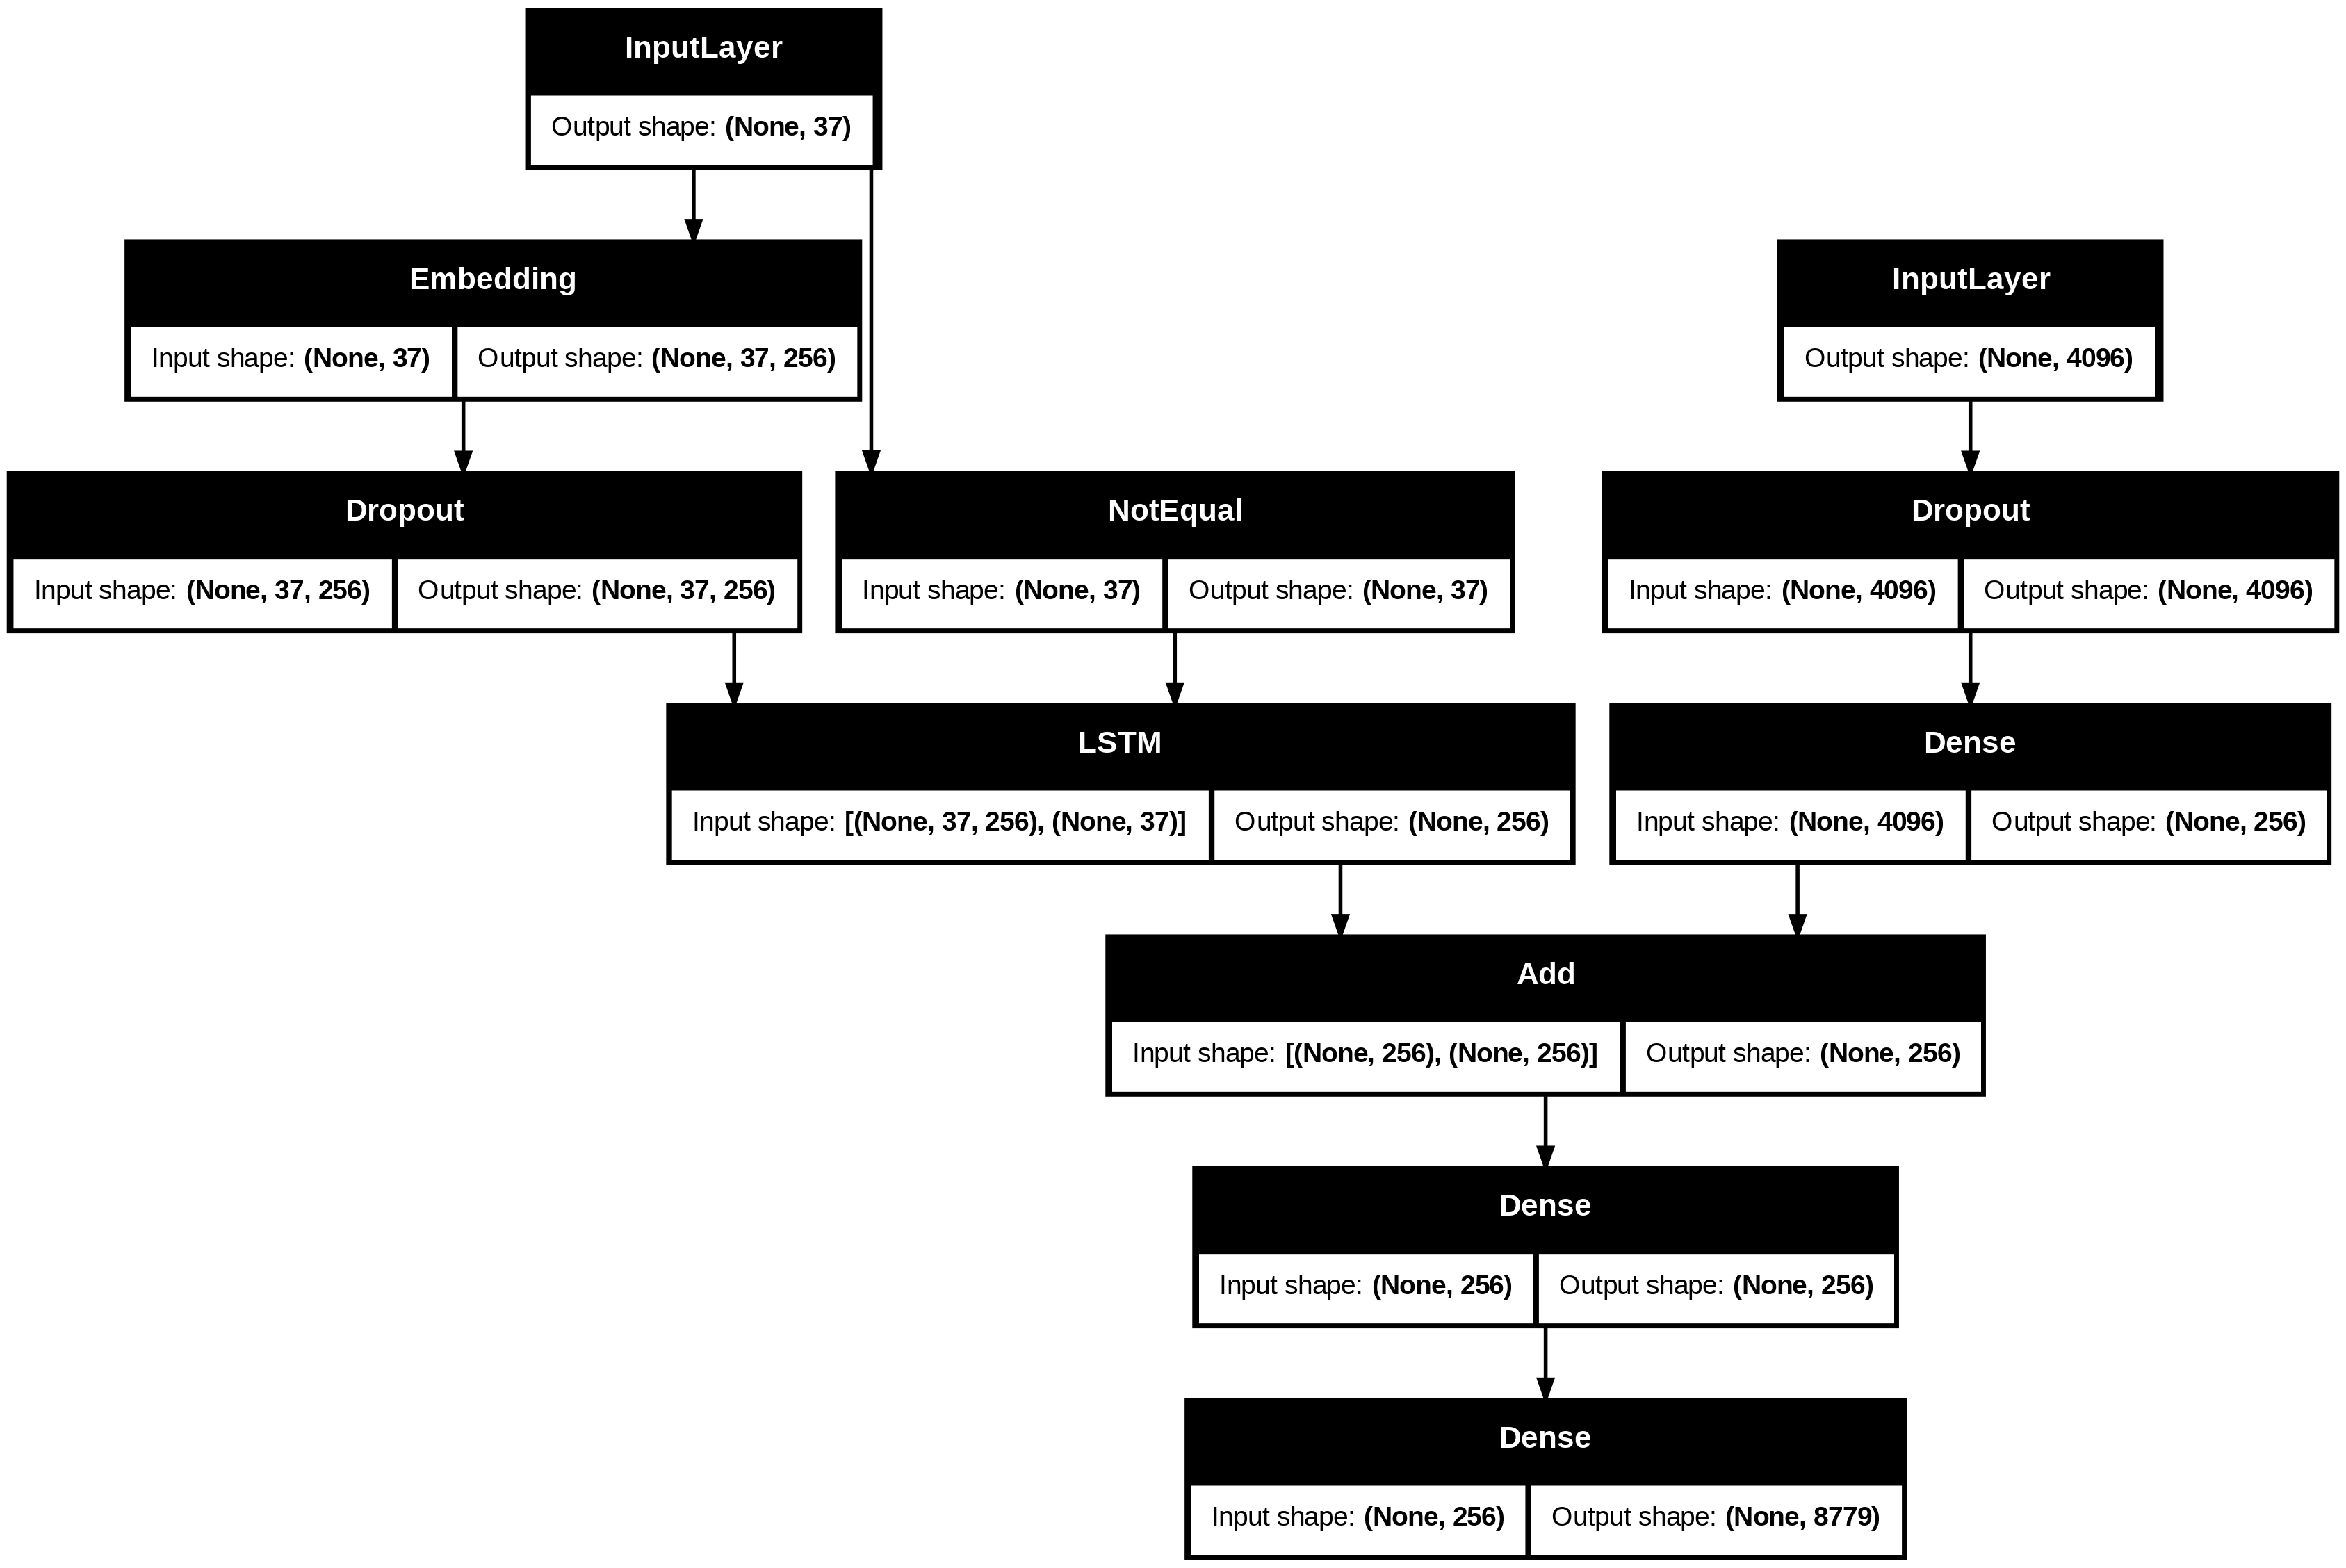

In [7]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [8]:
epoches = 5
batch_size = 128
output_types  = ((tf.float32, tf.int32), tf.int32)
output_shapes = (((4096,), (max_length,)), ())  
train_ds = tf.data.Dataset.from_generator(
    lambda: caption_example_generator(train, captions_dict, features, tokenizer, max_length),
    output_types=output_types,
    output_shapes=output_shapes
)
train_ds = train_ds.shuffle(10_000) \
                   .batch(batch_size) \
                   .map(
                       lambda inputs, y: (inputs, tf.one_hot(y, depth=vocab_size)),
                       num_parallel_calls=tf.data.AUTOTUNE
                   ) \
                   .prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_generator(
    lambda: caption_example_generator(test, captions_dict, features, tokenizer, max_length),
    output_types=output_types,
    output_shapes=output_shapes
)
val_ds = val_ds.batch(batch_size) \
               .map(
                   lambda inputs, y: (inputs, tf.one_hot(y, depth=vocab_size)),
                   num_parallel_calls=tf.data.AUTOTUNE
               ) \
               .prefetch(tf.data.AUTOTUNE)

total_train_samples = sum(
    (len(tokenizer.texts_to_sequences([cap])[0]) - 1)
    for key in train
    for cap in captions_dict[key]
)
total_val_samples = sum(
    (len(tokenizer.texts_to_sequences([cap])[0]) - 1)
    for key in test
    for cap in captions_dict[key]
)

train_steps = total_train_samples // batch_size
val_steps   = total_val_samples   // batch_size
history=model.fit(
    train_ds,
    epochs=epoches,
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    verbose=1
)


Epoch 1/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 192s 55ms/step - loss: 4.2584 - val_loss: 3.5377
Epoch 2/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 182s 54ms/step - loss: 3.1514 - val_loss: 3.4307
Epoch 3/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 183s 55ms/step - loss: 2.8913 - val_loss: 3.4374
Epoch 4/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 183s 55ms/step - loss: 2.7263 - val_loss: 3.5115
Epoch 5/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 184s 55ms/step - loss: 2.6086 - val_loss: 3.6123
Epoch 6/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 184s 55ms/step - loss: 2.5216 - val_loss: 3.6933
Epoch 7/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 184s 55ms/step - loss: 2.4578 - val_loss: 3.7841
Epoch 8/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 188s 56ms/step - loss: 2.4008 - val_loss: 3.8357
Epoch 9/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 187s 56ms/step - loss: 2.3572 - val_loss: 3.9372
Epoch 10/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 184s 55ms/step - loss: 2.3224 - val_loss: 4.0015
Epoch 11/15
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 184s 55ms/step - loss: 2.2910 - val_loss: 4.08

In [9]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [10]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length ,padding= 'post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'end':
            break
    return in_text


In [11]:
actual, predicted= list(),list()

for key in tqdm(test):
    cap = captions_dict[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in cap]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1:",corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2:",corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

100%|██████████| 810/810 [13:49<00:00,  1.02s/it]


BLEU-1: 0.5454076367389061
BLEU-2: 0.3565821997958819


In [12]:
from PIL import Image
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, image_name)
    img = Image.open(img_path)
    captions = captions_dict[image_id]
    print("actual")
    for cap in captions:
        print(cap)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("predicted:")
    print(y_pred)
    plt.imshow(img)

actual
start a man holding up a big yellow tent end
start a man holding up a yellow tent end
start a man holds a tent on a mountain campsite end
start a person is picking up a yellow tent by his or herself in the great outdoors end
start the man holds his tent up over his head end
predicted:
start a group of people are standing on a river ride snowmobiles end
actual
start a pug dog is standing up on two legs looking over a stone wall end
start a white dog on a green leash is standing on its hind legs to look over a stone wall end
start dog on a leash looking over a stone wall end
start the leashed dog is looking over the stone wall end
start the white dog is standing on its hind legs looking over a ledge end
predicted:
start a dog is running through a forest end
actual
start a group of girls playing field hockey end
start five female hockey players are scrambling for the ball around the goal mouth end
start girls play field hockey end
start the field hockey players scramble in front of

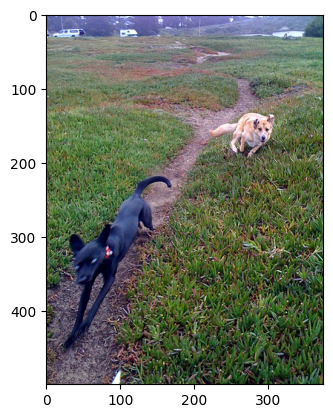

In [13]:
for img_id in test[:5]:
    generate_caption(img_id+'.jpg')

actual
start an african man in blue jeans is holding the hands of two boys that are eating ice creams end
start man holds the hand of two children end
start the man is holding the hands of two boys end
start two boys eating ice cream are holding the hands of an adult end
start two young boys hold a man s hands end
predicted:
start a man in a black shirt and jeans is walking with a man in a red shirt end
actual
start a man in a beige trench coat is walking in the rain end
start a man in a tan trench coat and blue jeans walks with a black umbrella open over his head end
start a man in a trench coat is walking with an umbrella end
start a man with white hair a long trench coat and an umbrella walks past a parking meter end
start man walking with his umbrella in a bleak street end
predicted:
start a man in a white shirt and jeans walks down the sidewalk end
actual
start a group of people are lounging at a beach end
start a group of sunbathers gather near some kayaks at the beach end
start 

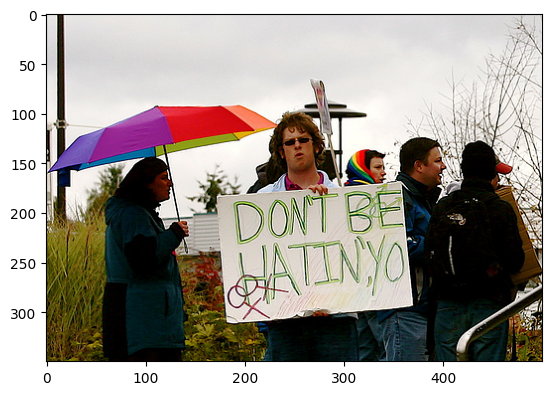

In [14]:
for img_id in train[:4]:
    generate_caption(img_id+'.jpg')